# Question 6

This script starts uses the impulse response of a low pass FIR filter designed using the Parks-McClellan method to infer various features of the filter.

In [30]:
import numpy as np

# Define the positive half of the impulse response: h[0] to h[3]
h = np.array([0.4983, 0.3696, 0.1201, -0.1294])

# Coefficients of H(x) (ref. working in assignment)
Hx_coef = [h[0] - 2 * h[2], 2 * (h[1] - 3 * h[3]), 4 * h[2], 8 * h[3]]
print(f" H(x) = {Hx_coef[3]}x^3 + {Hx_coef[2]}x^2 + {Hx_coef[1]}x + {Hx_coef[0]}")

# Coefficients of dH(x)
dHx_coef = [i * b for i, b in enumerate(Hx_coef)][1:]
print(f"dH(x) = {dHx_coef[2]}x^2 + {dHx_coef[1]}x + {dHx_coef[0]}")

 H(x) = -1.0352x^3 + 0.4804x^2 + 1.5156x + 0.2581
dH(x) = -3.1056x^2 + 0.9608x + 1.5156


In [44]:
from numpy.polynomial.polynomial import Polynomial

# Define the polynomials H(x) and dH(x)
Hx = Polynomial(Hx_coef)
dHx = Polynomial(dHx_coef)

# Roots of dH(x) are the extrema of H(x)
x_extrema = dHx.roots()
print(f"Extrema of H(x): x = {x_extrema[0]:8.5f}, {x_extrema[1]:8.5f}")

# Convert extrema of H(x) to extrema of H(w); x = cos(w)
w_extrema = np.arccos(x_extrema)
print(f"Extrema of H(w): w = {w_extrema[0]:8.5f}, {w_extrema[1]:8.5f} (rad)")

Extrema of H(x): x = -0.56082,  0.87020
Extrema of H(w): w =  2.16617,  0.51520 (rad)


In [63]:
# Helper function for converting frequency response to dB scale
dB = lambda x: 20 * np.log10(x)

# Calculate pass and stop band ripple magnitudes
H_min, H_max= Hx(x_extrema)
delta_p =  H_max - 1
delta_s = -H_min
print(f"Pass band ripple: {delta_p:.5f} or {dB(delta_p):.5f} (dB)")
print(f"Stop band ripple: {delta_s:.5f} or {dB(delta_s):.5f} (dB)")

Pass band ripple: 0.25860 or -11.74728 (dB)
Stop band ripple: 0.25819 or -11.76133 (dB)


In [68]:
# Calculate cutoff frequency: x_c such that H(x_c) = 1 - delta_p => 0 = H(x_c) - (1 - delta_p)
x_c = Polynomial([Hx_coef[0] - (1 - delta_p)] + Hx_coef[1:]).roots()
print("Possible x_c:", ", ".join(f"{x:.5f}" for x in x_c))

# Calculate stopband frequency: x_s such that H(x_s) = delta_s => 0 = H(x_s) - delta_s
x_s = Polynomial([Hx_coef[0] - delta_s] + Hx_coef[1:]).roots()
print("Possible x_s:", ", ".join(f"{x:.5f}" for x in x_s), "\n")

# x_c and x_s must be between the extrema, which limits both cases to only 1 option
x_c, = [x for x in x_c if x_extrema[0] < x < x_extrema[1]]
x_s, = [x for x in x_s if x_extrema[0] < x < x_extrema[1]]
w_c = np.arccos(x_c)
w_s = np.arccos(x_s)
print(f"x_c = {x_c:.5f} => w_c = {w_c:.5f} (rad)")
print(f"x_s = {x_s:.5f} => w_c = {w_s:.5f} (rad)")

Possible x_c: -1.15444, 0.30877, 1.30974
Possible x_s: -1.00003, 0.00006, 1.46404 

x_c = 0.30877 => w_c = 1.25690 (rad)
x_s = 0.00006 => w_c = 1.57074 (rad)


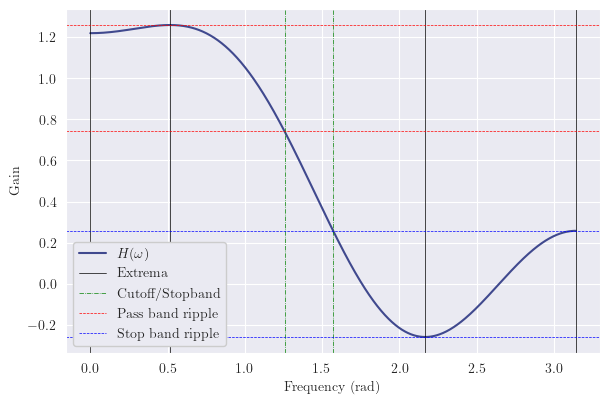

In [76]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from a2_config import A2_ROOT, SAVEFIG_CONFIG

# Plot the filter in cos(w) and overlay the identified features
w = np.linspace(0, np.pi, 1024, endpoint=False)
H = lambda w: Hx_coef[3] * np.power(np.cos(w), 3) + \
              Hx_coef[2] * np.square(np.cos(w)) + \
              Hx_coef[1] * np.cos(w) + \
              Hx_coef[0]

fig, ax = plt.subplots(figsize=(6, 4))
fig.tight_layout()

# Frequency response
sns.lineplot(x=w, y=H(w), ax=ax, label="$H(\omega)$")
# Extrema
ax.axvline(0,            c="k", lw=0.5, ls="-", label="Extrema")
ax.axvline(w_extrema[1], c="k", lw=0.5, ls="-")
ax.axvline(w_extrema[0], c="k", lw=0.5, ls="-")
ax.axvline(np.pi,        c="k", lw=0.5, ls="-")
# Cutoff and stopband frequencies
ax.axvline(w_c,          c="g", lw=0.5, ls="-.", label="Cutoff/Stopband")
ax.axvline(w_s,          c="g", lw=0.5, ls="-.")
# Pass and stop band ripples
ax.axhline(1 + delta_p,  c="r", lw=0.5, ls="--", label="Pass band ripple")
ax.axhline(1 - delta_p,  c="r", lw=0.5, ls="--")
ax.axhline(0 + delta_s,  c="b", lw=0.5, ls="--", label="Stop band ripple")
ax.axhline(0 - delta_s,  c="b", lw=0.5, ls="--")
# Axis labels
ax.set_xlabel("Frequency (rad)")
ax.set_ylabel("Gain")
ax.legend(loc="lower left", framealpha=1)

fname = Path(A2_ROOT, "output", "q6_plot_everything.png")
fig.savefig(fname, **SAVEFIG_CONFIG)